In [1]:
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/terracotta")
import terracotta as tct
import tskit
import pandas as pd
from glob import glob
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
demes = pd.read_csv("dataset/demes.tsv", sep="\t")
samples = pd.read_csv("dataset/samples.tsv", sep="\t")
world_map = tct.WorldMap(demes, samples)

In [3]:
paths = [path for path in glob("dataset/trees/*")][:1]

In [5]:
# This doesn't work anymore now that I'm not using `record_migrations=True`
ts = tskit.load(paths[0])
migs = ts.tables.migrations
G = world_map.convert_to_networkx_graph()
for m in migs:
    actual_source = int(ts.population(m.source).metadata["name"].split("_")[-1])
    actual_dest = int(ts.population(m.dest).metadata["name"].split("_")[-1])
    if nx.shortest_path_length(G, actual_source, actual_dest) > 1:
        print(
            m.source,
            m.dest,
            actual_source,
            actual_dest,
            nx.shortest_path_length(G, actual_source, actual_dest)
        )

In [9]:
# This just checks that migrations work as expected, no need to run
a = 0
current_pos = None
while a != -1:
    found = np.where(migs.node==a)[0]
    #if len(found) > 0:
    #    for f in found:
    #        sd = migs[f]
    #        print(a, int(ts.population(sd.source).metadata["name"].split("_")[-1]), int(ts.population(sd.dest).metadata["name"].split("_")[-1]))
    new_pos = int(ts.population(ts.node(a).population).metadata["name"].split("_")[-1])
    #if current_pos != None and nx.shortest_path_length(G, current_pos, new_pos) > 1:
    #    print(a)
    #print(a, ts.node(a).time, new_pos)
    a = ts.first().parent(a)
    current_pos = new_pos

0 0.0 238
5153 64.31587473433277 238
5443 80.34034144117912 581
6025 115.2645084266965 238
6623 160.98328023462693 510
6762 170.11067024522242 273
6892 181.29106559505456 220
6969 188.52265774509692 207
7126 201.15059648101163 865
7197 206.9153619862155 60
7518 234.25782299222476 865
7766 255.2663259065375 60
7877 265.9738651890479 865
8072 283.8373657758813 833
8232 302.12258467336466 63
8257 304.6998370115541 865
8373 317.99994617900563 60
8522 333.98704140666655 865
8610 343.7208249022179 833
8720 354.1440978476626 865
8871 371.82000645987915 207
8998 385.29551010839435 60
9096 398.264489925985 570
9319 420.9484918033094 60
9330 422.5486313876025 865
9435 436.96169654664834 63
9532 449.4904089723833 833
9666 466.1894832407394 865
9800 483.46185007420195 63
9880 494.8900079697959 833
9904 499.8903274462733 769
10029 518.8857673274889 63
10077 524.6096544725956 833
10261 553.3418147210108 769
10265 553.8898829853571 165
10509 589.7433349174091 769
10680 618.0601627686767 165
10683 618

In [4]:
sample = 0

path = []
time = []
deme = []
for p in paths:
    ts = tskit.load(p)
    a = sample
    while a != -1:
        path.append(p)
        time.append(ts.node(a).time)
        deme.append(int(ts.population(ts.node(a).population).metadata["name"].split("_")[-1]))
        a = ts.first().parent(a)

df = pd.DataFrame({"file":path, "time":time, "deme":deme})

estimated_positions_informed = tct.track_lineage_over_time(
    sample=sample,
    times=range(0,6000,1000),
    tree=ts.simplify().first(),
    world_map=world_map,
    migration_rates=np.array([0.01, 0.01, 0.01])
)

In [5]:
single_sample = samples.loc[samples["id"]==sample,].reset_index(drop=True)
single_sample["id"] = 0
world_map_single = tct.WorldMap(demes, single_sample)
uninformed_ts = ts.simplify(samples=[sample], keep_input_roots=True)

estimated_positions_uninformed = tct.track_lineage_over_time(
    sample=0,
    times=range(0,6000,1000),
    tree=uninformed_ts.first(),
    world_map=world_map_single,
    migration_rates=np.array([0.01, 0.01, 0.01])
)

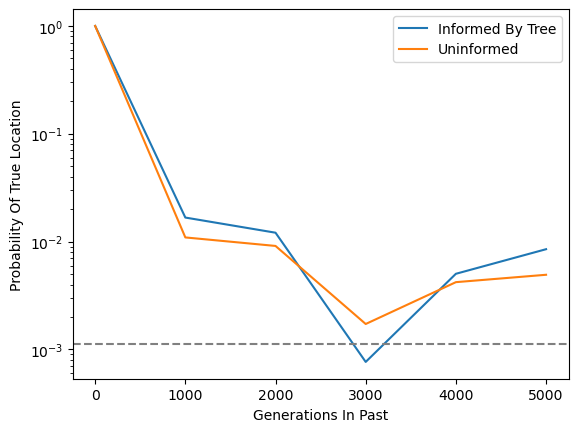

In [6]:
times = []
probs_informed = []
probs_uninformed = []
for time in range(0, 6000, 1000):
    points = []
    for p in paths:
        filtered = df.loc[df["file"]==p,:].loc[df["time"]<=time,:]
        deme = filtered.loc[filtered["time"]==filtered["time"].max(),"deme"].iloc[0]
        prob_informed = estimated_positions_informed[time][0][np.where(world_map.demes["id"] == deme)[0][0]]
        prob_uninformed = estimated_positions_uninformed[time][0][np.where(world_map.demes["id"] == deme)[0][0]]
        times.append(time)
        probs_informed.append(prob_informed)
        probs_uninformed.append(prob_uninformed)
plt.plot(times, probs_informed, label="Informed By Tree")
plt.plot(times, probs_uninformed, label="Uninformed")
plt.axhline(1/len(world_map.demes), linestyle="dashed", color="grey")
plt.yscale("log")
plt.legend()
plt.xlabel("Generations In Past")
plt.ylabel("Probability Of True Location")
#plt.savefig("ancestral_location_probability.svg")
plt.show()  

In [8]:
sample = 1

path = []
time = []
deme = []
for p in paths:
    ts = tskit.load(p)
    a = sample
    while a != -1:
        path.append(p)
        time.append(ts.node(a).time)
        deme.append(int(ts.population(ts.node(a).population).metadata["name"].split("_")[-1]))
        a = ts.first().parent(a)
df_1 = pd.DataFrame({"file":path, "time":time, "deme":deme})

estimated_positions_informed_1 = tct.track_lineage_over_time(
    sample=sample,
    times=range(0,4010,10),
    tree=ts.simplify().first(),
    world_map=world_map,
    migration_rates=np.array([0.01, 0.01, 0.01])
)

single_sample = samples.loc[samples["id"]==sample,].reset_index(drop=True)
single_sample["id"] = 0
world_map_single = tct.WorldMap(demes, single_sample)
uninformed_ts = ts.simplify(samples=[sample], keep_input_roots=True)

estimated_positions_uninformed_1 = tct.track_lineage_over_time(
    sample=0,
    times=range(0,4010,10),
    tree=uninformed_ts.first(),
    world_map=world_map_single,
    migration_rates=np.array([0.01, 0.01, 0.01])
)

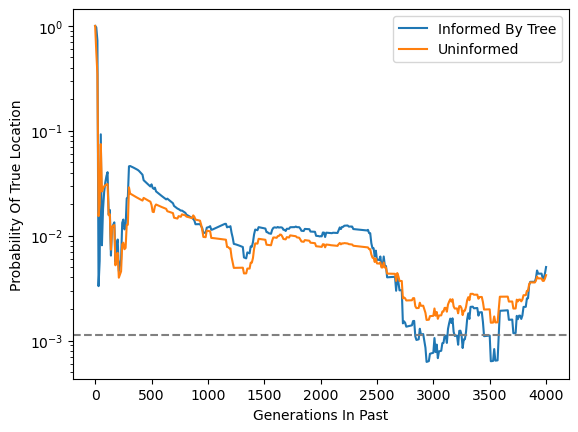

In [9]:
times = []
probs_informed = []
probs_uninformed = []
for time in range(0, 4010, 10):
    points = []
    for p in paths:
        filtered = df_1.loc[df_1["file"]==p,:].loc[df_1["time"]<=time,:]
        deme = filtered.loc[filtered["time"]==filtered["time"].max(),"deme"].iloc[0]
        prob_informed = estimated_positions_informed_1[time][0][np.where(world_map.demes["id"] == deme)[0][0]]
        prob_uninformed = estimated_positions_uninformed_1[time][0][np.where(world_map.demes["id"] == deme)[0][0]]
        times.append(time)
        probs_informed.append(prob_informed)
        probs_uninformed.append(prob_uninformed)
plt.plot(times, probs_informed, label="Informed By Tree")
plt.plot(times, probs_uninformed, label="Uninformed")
plt.axhline(1/len(world_map.demes), linestyle="dashed", color="grey")
plt.yscale("log")
plt.legend()
plt.xlabel("Generations In Past")
plt.ylabel("Probability Of True Location")
#plt.savefig("ancestral_location_probability.svg")
plt.show()

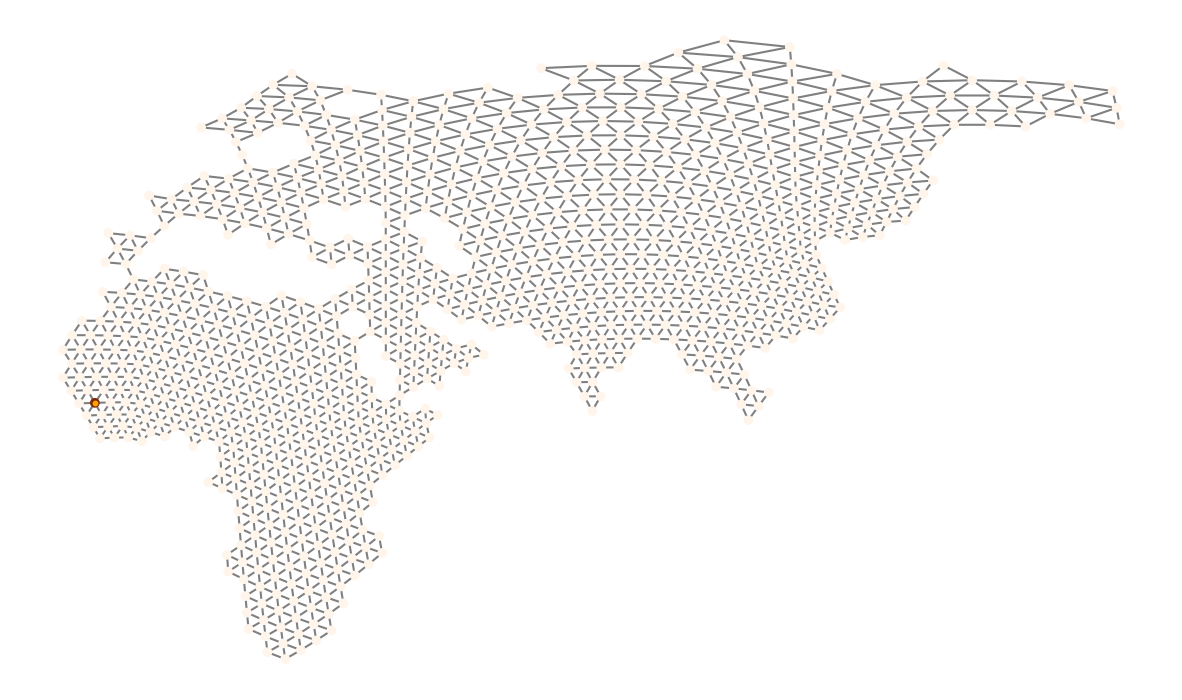

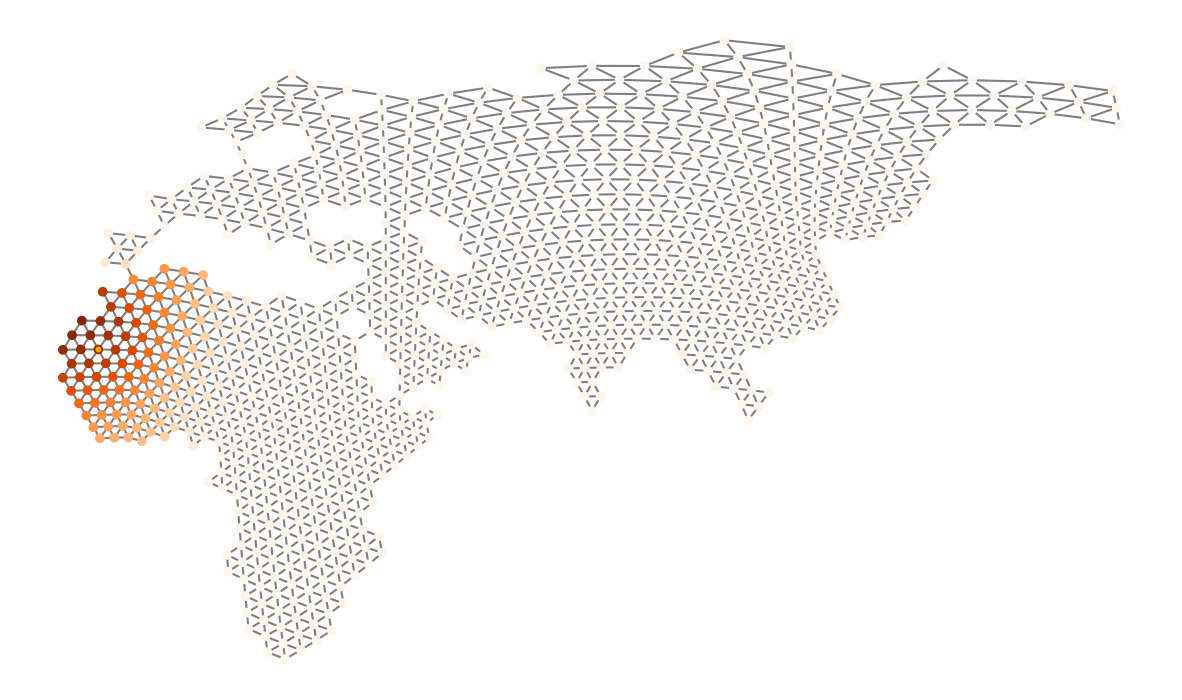

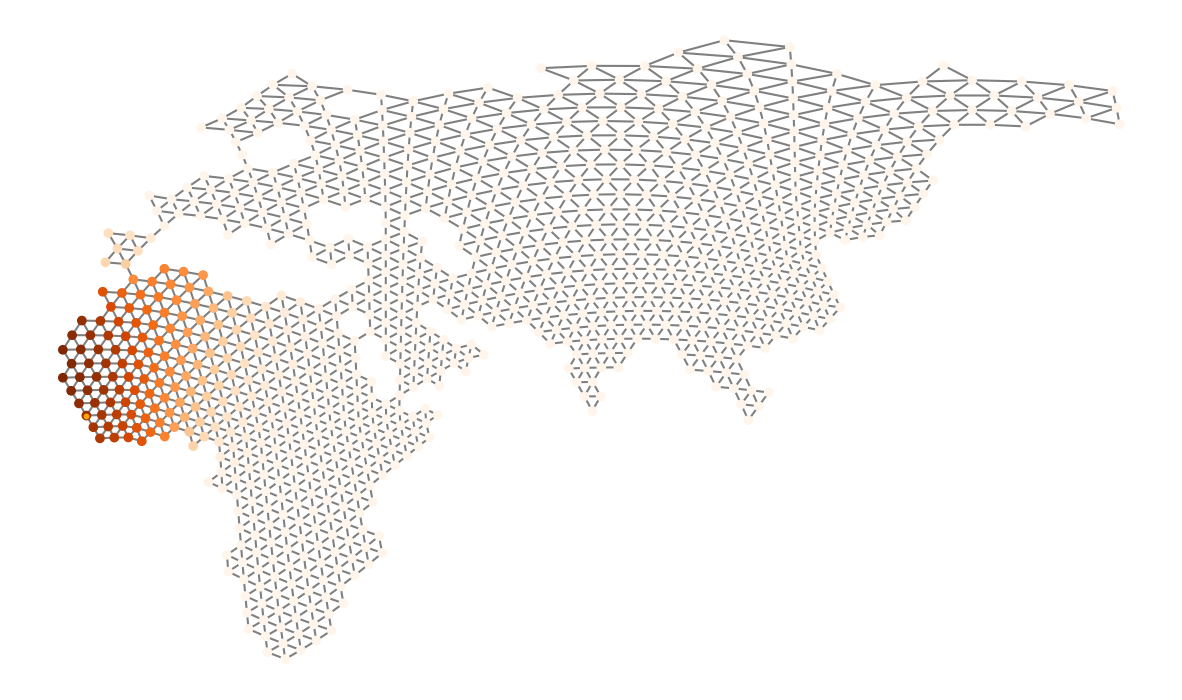

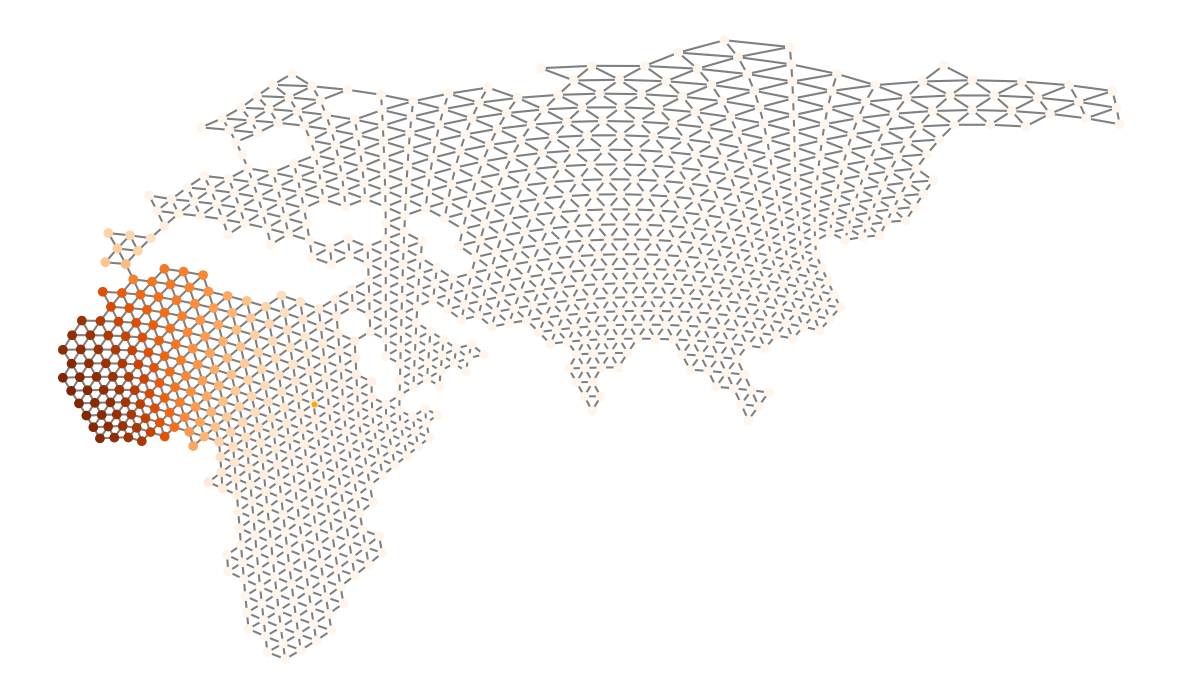

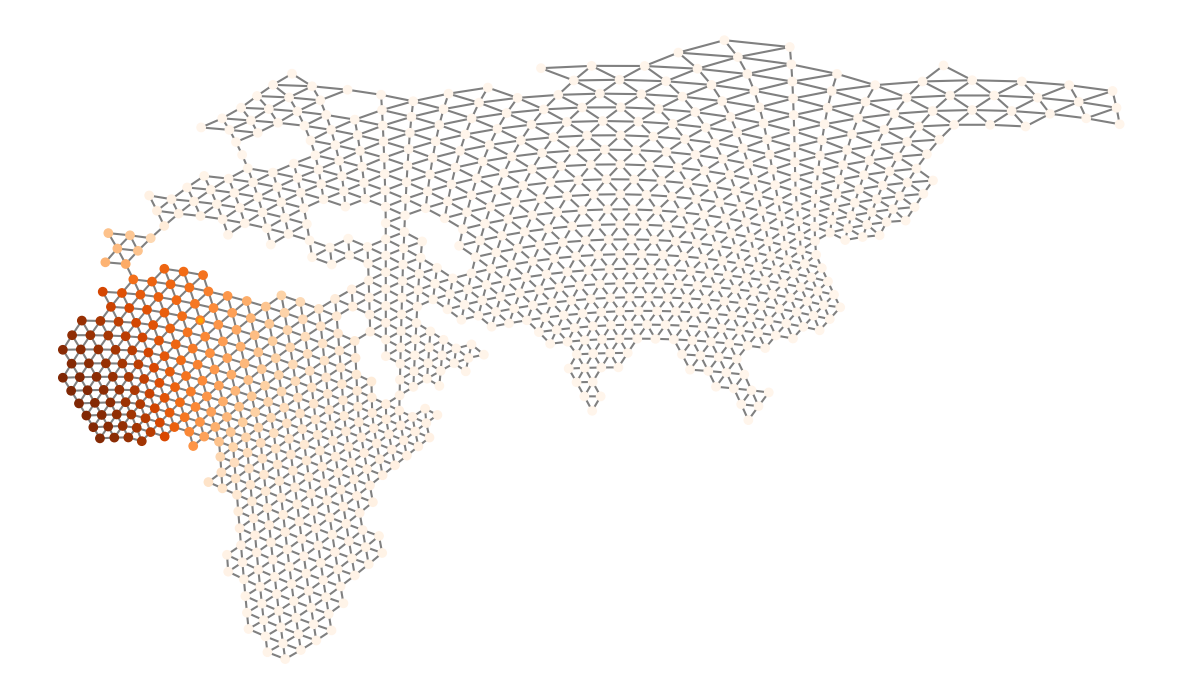

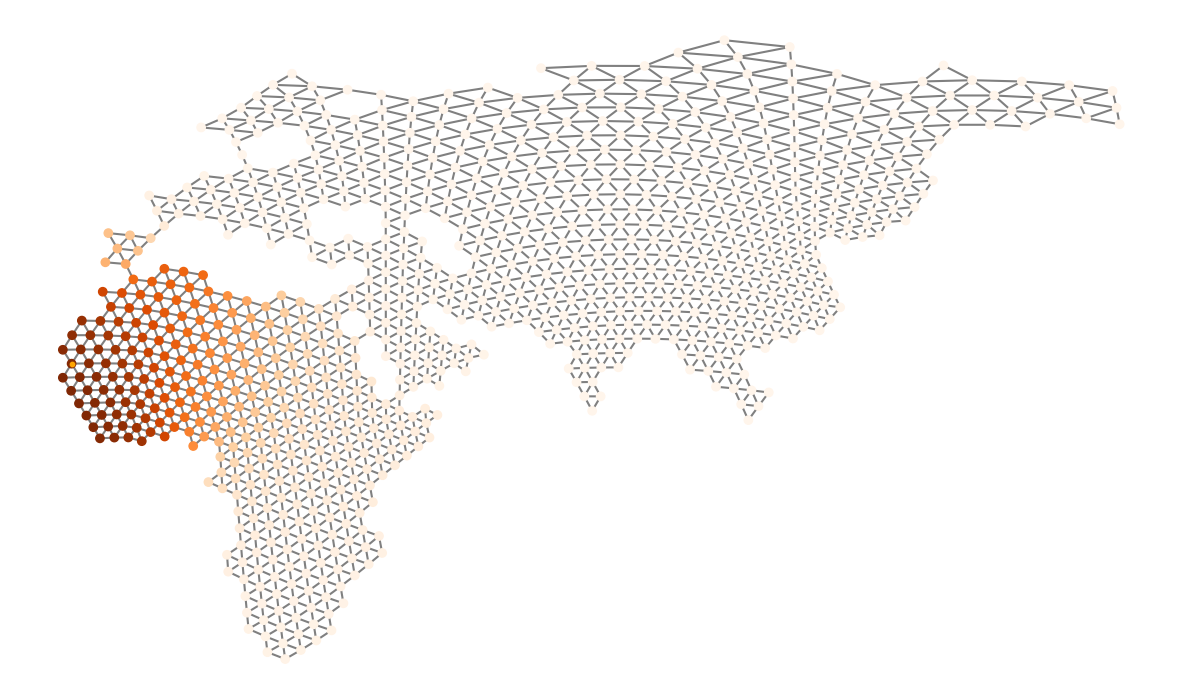

In [8]:
for time in range(0, 6000, 1000):
    filtered = df.loc[df["file"]==p,:].loc[df["time"]<=time,:]
    deme = filtered.loc[filtered["time"]==filtered["time"].max(),"deme"].iloc[0]
    world_map.draw_estimated_location(location_vector=estimated_positions_informed[time], figsize=(15,15), add_points=[deme])

In [ ]:
for time in range(0, 6000, 1000):
    world_map.draw_estimated_location(location_vector=estimated_positions_uninformed[time], figsize=(15,15))

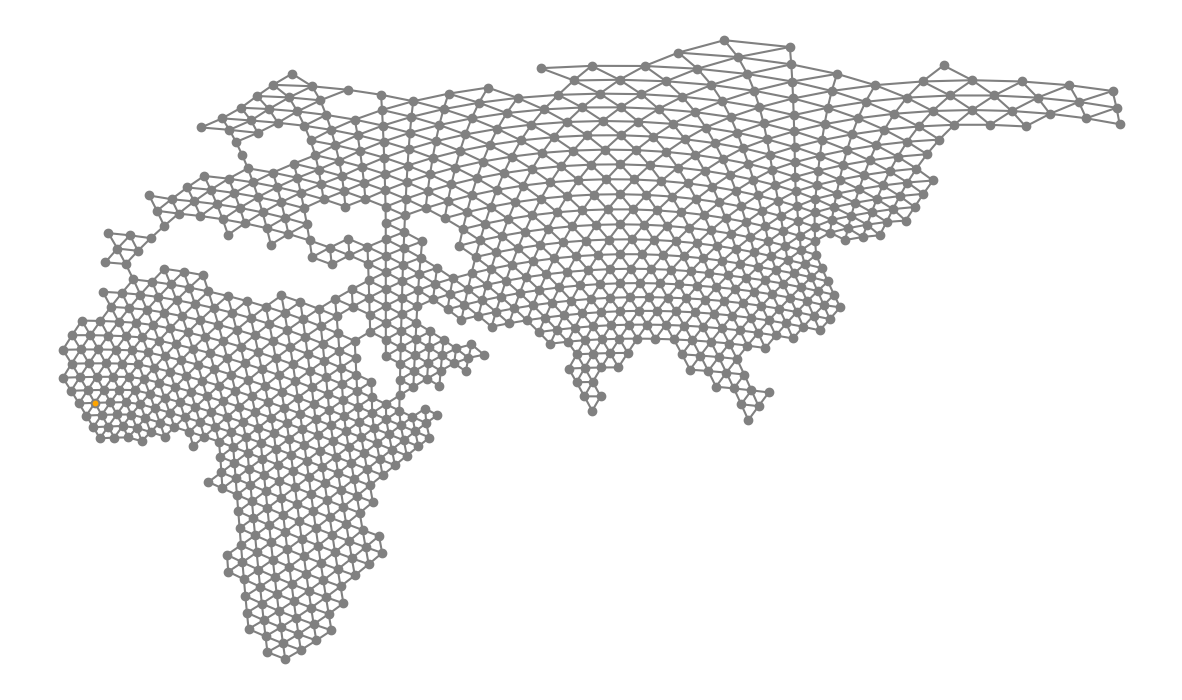

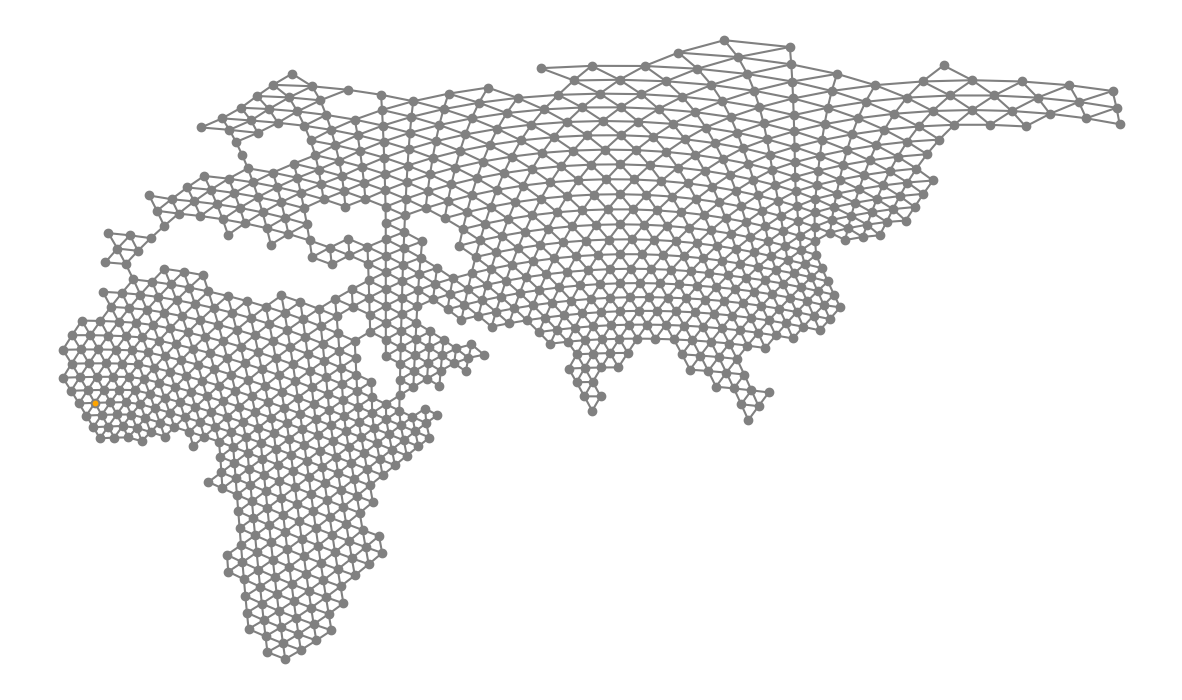

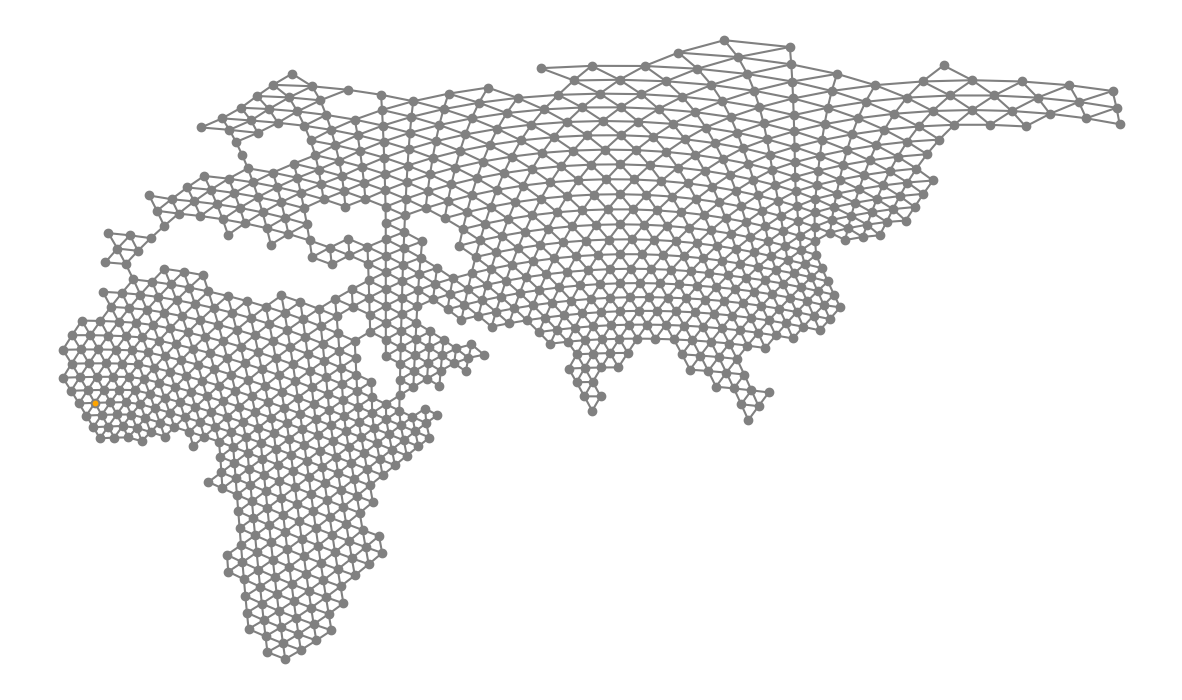


KeyboardInterrupt

Exception ignored in: Traceback (most recent call last):
  File "_zmq.py", line 169, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt
'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "_zmq.py", line 169, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


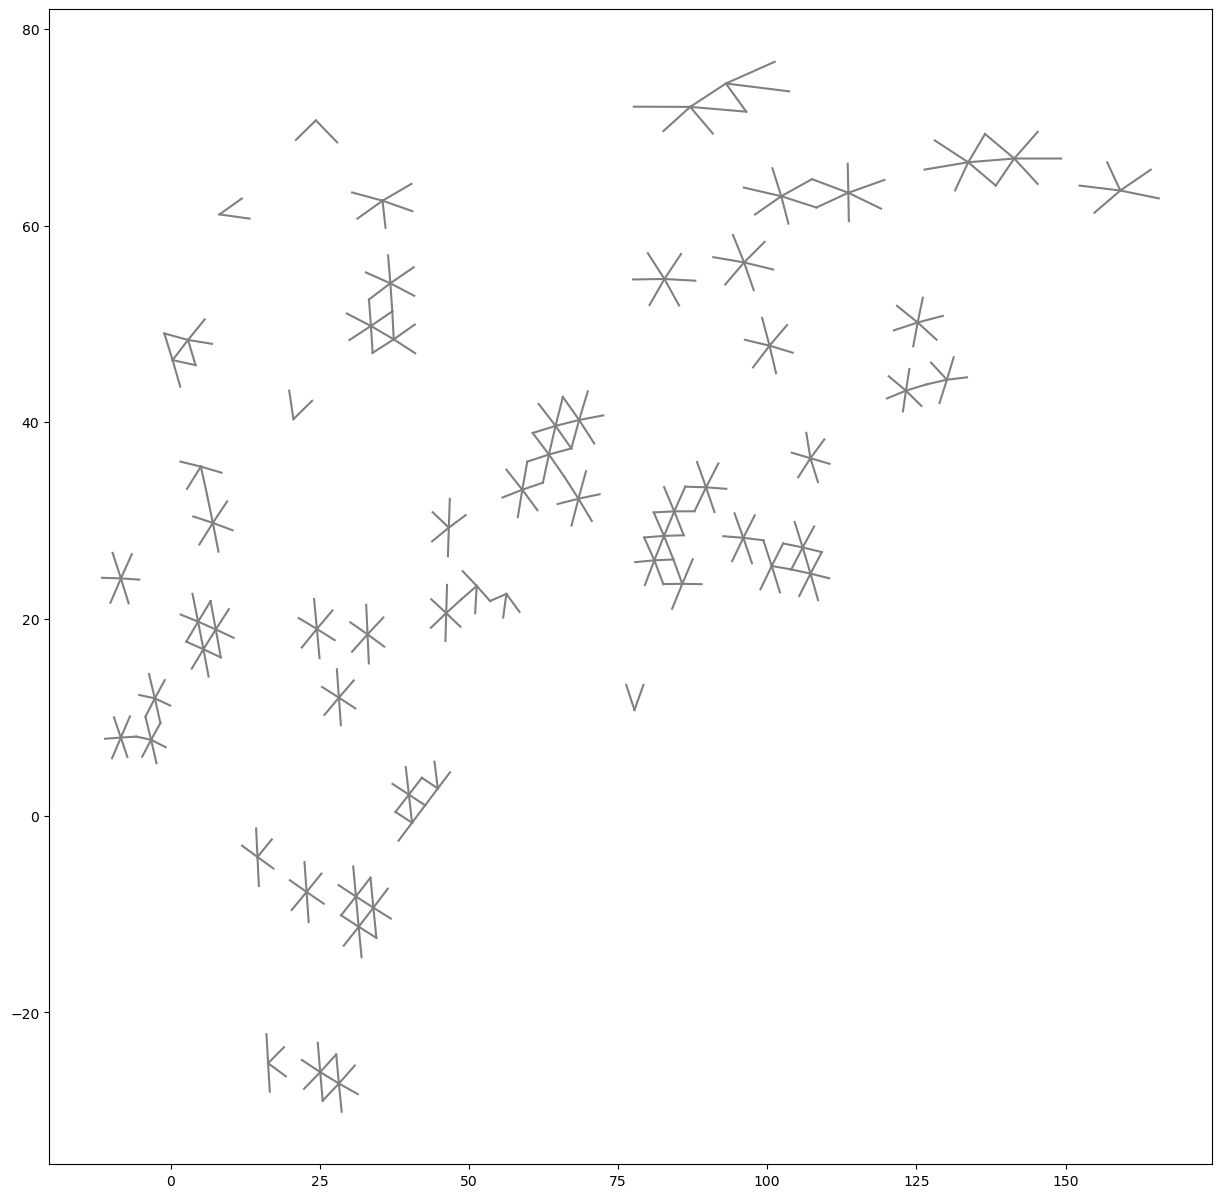

In [10]:
for time in range(0, 110, 10):
    points = []
    for p in paths:
        filtered = df.loc[df["file"]==p,:].loc[df["time"]<=time,:]
        deme = filtered.loc[filtered["time"]==filtered["time"].max(),"deme"].iloc[0]
        points.append(deme)
    world_map.draw(figsize=(15,15), add_points=points)